In [4]:
import os
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from Bio import SeqIO
import torch 
from keras.models import Sequential, load_model, Model 
from keras.layers import Dense, Activation, Flatten, Dropout, Input, BatchNormalization, Activation, add, MaxPooling1D, Cropping1D, Bidirectional, LSTM 
from keras.layers.convolutional import Conv1D
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt 
import keras.backend as kb

In [2]:
genomeFastaPos='/Users/harrys/Documents/DeepM6ASeqRecreate/DeepM6ASeq-master/data/data/hs/train_pos.fa'
seqsPos=SeqIO.parse(open(genomeFastaPos),'fasta')
genomFastaNeg='/Users/harrys/Documents/DeepM6ASeqRecreate/DeepM6ASeq-master/data/data/hs/train_neg.fa'
seqsNeg=SeqIO.parse(open(genomFastaNeg),'fasta')
#seqsPos=[s.name.split(':')[-1].split('(')[0] for s in seqsPos]
#seqsNeg=[s.name.split(':')[-1].split('(')[0] for s in seqsNeg]
Prs=[]
i=0
for s in seqsPos:
    nm=s.name.split(':')[-1].split('(')[0]
    nm=nm.split('-')
    r=(int(nm[0]),int(nm[1]))
    Prs=Prs+list(range(r[0],r[1]))
    i+=1
    if i%5000==0: break

Nrs=[]
i=0
for s in seqsPos:
    nm=s.name.split(':')[-1].split('(')[0]
    nm=nm.split('-')
    r=(int(nm[0]),int(nm[1]))
    Nrs=Nrs+list(range(r[0],r[1]))
    i+=1
    if i%5000==0: break
Prs=pd.Series(Prs)
Nrs=pd.Series(Nrs)


In [3]:
genomeFastaPos='/Users/harrys/Documents/DeepM6ASeqRecreate/DeepM6ASeq-master/data/data/hs/train_pos.fa'
seqsPos=SeqIO.parse(open(genomeFastaPos),'fasta')
ss=[]
for s in seqsPos:
    sq=s.seq
    z=[i for i in range(len(sq)) if sq[i]=='A']
    ss=ss+z


KeyboardInterrupt: 

In [ ]:
pd.Series(ss).value_counts().sort_values()

In [ ]:
genomeFastaPos='/Users/harrys/Documents/DeepM6ASeqRecreate/DeepM6ASeq-master/data/data/hs/train_pos.fa'
seqsPos=SeqIO.parse(open(genomeFastaPos),'fasta')
Prs=[]
for s in seqsPos:
    nm=s.name
    Prs.append(nm)

In [ ]:
Prs[0:]

In [ ]:
#lens=pd.Series(lens)
#lens[lens!=102]
Prs.size

In [ ]:
Prs[:30]

In [ ]:
seqsPos=[s for s in seqsPos]
seqsNeg=[s for s in seqsNeg]


In [ ]:
seqsPos[2000:2010]

In [5]:
def load_train_test_bicoding(pos_train_fa,neg_train_fa,pos_test_fa,neg_test_fa,vec_len):
    data_pos_train = []
    data_neg_train = []
    data_pos_test = []
    data_neg_test = []

    data_pos_train = load_data_bicoding(pos_train_fa)
    data_neg_train = load_data_bicoding(neg_train_fa)
    data_pos_test = load_data_bicoding(pos_test_fa)
    data_neg_test = load_data_bicoding(neg_test_fa)

    data_train = np.array([_ + [1] for _ in data_pos_train] + [_ + [0] for _ in data_neg_train])
    np.random.seed(42)
    np.random.shuffle(data_train)

    X_train = np.array([_[:-1] for _ in data_train])
    y_train = np.array([_[-1] for _ in data_train])

    X_test = np.array([_ for _ in data_pos_test] + [_ for _ in data_neg_test])
    y_test = np.array([1 for _ in data_pos_test] + [0 for _ in data_neg_test])
    #print(X_train.shape[1])
    X_train = X_train.reshape(X_train.shape[0], int(X_train.shape[1]/vec_len), vec_len)
    X_test = X_test.reshape(X_test.shape[0], int(X_test.shape[1]/vec_len), vec_len)
    return X_train,y_train,X_test,y_test

def load_data_bicoding(in_fa):
    data=[]
    for record in SeqIO.parse(in_fa, "fasta"):
        seq=str(record.seq)
        bicoding=convert_seq_to_bicoding(seq)
        data.append(bicoding)
    #print(len(data))
    return data

def convert_seq_to_bicoding(seq,wsize=101):
    #return bicoding for a sequence
    seq=seq.replace('U','T') #turn rna seq to dna seq if have
    feat_bicoding=[]
    bicoding_dict={'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    if len(seq)<101:
        seq=seq+'N'*(101-len(seq))
    for each_nt in seq:
        feat_bicoding+=bicoding_dict[each_nt]
    return feat_bicoding



In [6]:
os.chdir("/Users/harrys/Documents/DeepM6ASeqRecreate/DeepM6ASeq-master/data/data/hs/.")

In [7]:
X_train,y_train,X_test,y_test = load_train_test_bicoding('train_pos.fa','train_neg.fa','test_pos.fa','test_neg.fa',4)

In [8]:
[print(i.shape) for i in [X_train,y_train,X_test,y_test]]

(49050, 101, 4)
(49050,)
(12611, 101, 4)
(12611,)


[None, None, None, None]

In [98]:
#pad sequences (X_train and X_test) by half a filter 
def pad(X,FltW):
    ln=X.shape[1]+FltW
    X_pads=np.zeros((X.shape[0],ln,4))
    low=int(FltW/2-1)
    high=int(ln-FltW/2-1)
    for i in range(X_pads.shape[0]):
        X_pads[i,low:high]=X[i]
    return X_pads

In [99]:
def binary_crossentropy_custom(y_true, y_pred):
    return - kb.mean(y_true*kb.log(y_pred+1e-10) + (1-y_true)*kb.log(1-y_pred+1e-10))

In [100]:
X_train=pad(X_train,10)
X_test=pad(X_test,10)

inputs = Input(shape=(None,4))
z=Conv1D(256,kernel_size=10,padding='valid',activation='relu')(inputs)
z=BatchNormalization()(z)
z=Dropout(0.5)(z)
z=Conv1D(128,kernel_size=5,padding='valid',activation='relu')(z)
z=BatchNormalization()(z)
z=Dropout(0.5)(z)
z=Bidirectional(LSTM(64,activation='tanh'))(z)
z=Dense(64,activation='relu')(z)
predictions=Dense(1,activation='sigmoid')(z)

model = Model(inputs,predictions)
#default lr of adam is 0.001 
model.compile(optimizer='adam',loss=binary_crossentropy_custom)

hstry = keras.callbacks.History()
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
mcp = keras.callbacks.ModelCheckpoint('model_weights.hdf5',monitor = 'val_loss',save_best_only = True)

#50 epochs 
model.fit(X_train,y_train,batch_size=256,epochs=50,validation_split=0.125,
          callbacks=[hstry,mcp,earlyStop],verbose=1)
#save model 
json_string = model.to_json()
open('model_arch.json', 'w').write(json_string)
model.save_weights('model_weights.h5')


Train on 42918 samples, validate on 6132 samples
Epoch 1/50
42918/42918 [==============================] - 111s 3ms/step - loss: 0.6828 - val_loss: 0.6509
Epoch 2/50
42918/42918 [==============================] - 107s 2ms/step - loss: 0.6427 - val_loss: 0.6147
Epoch 3/50
42918/42918 [==============================] - 105s 2ms/step - loss: 0.6304 - val_loss: 0.6795
Epoch 4/50
42918/42918 [==============================] - 105s 2ms/step - loss: 0.6264 - val_loss: 0.5763
Epoch 5/50
42918/42918 [==============================] - 104s 2ms/step - loss: 0.5790 - val_loss: 0.5606
Epoch 6/50
42918/42918 [==============================] - 105s 2ms/step - loss: 0.5522 - val_loss: 0.5300
Epoch 7/50
42918/42918 [==============================] - 104s 2ms/step - loss: 0.5395 - val_loss: 0.5348
Epoch 8/50
42918/42918 [==============================] - 109s 3ms/step - loss: 0.5286 - val_loss: 0.5233
Epoch 9/50
42918/42918 [==============================] - 110s 3ms/step - loss: 0.5220 - val_loss: 0.51

In [101]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, None, 4)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, None, 256)         10496     
_________________________________________________________________
batch_normalization_35 (Batc (None, None, 256)         1024      
_________________________________________________________________
dropout_35 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, None, 128)         163968    
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 128)         512       
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 128)         0         
__________

In [102]:
#calculate top-k and PR-AUC accuracies for SDs and SAs (seperatly)
p=model.predict(X_test)
p=p[:,0]
yT=[i for i in range(len(y_test)) if y_test[i] == 1]
pS=np.argsort(p)[-len(yT):]
pS=pd.Series(pS)
nCrct=pS[pS.isin(yT)].size
Tk=nCrct/len(yT)

PR=average_precision_score(y_test,p)

writeAccs=str(Tk)+','+str(PR)
open('Tks_PRs.txt', 'w').write(writeAccs)
writeAccs

'0.758839384810528,0.8201664510427521'

In [103]:
np.min(p)

0.0066534877

Text(0.5, 1.0, 'DeepM6A performance')

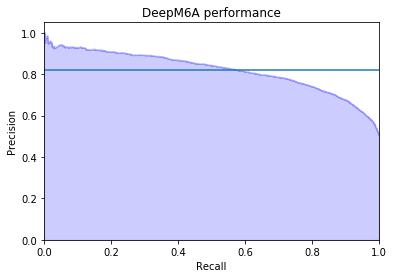

In [104]:
# graph Precision Recall of Splice Donor sites
precision, recall, _ = precision_recall_curve(y_test,p)


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.plot([0,1],[PR,PR])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('DeepM6A performance')

In [29]:
ones=[_ for _ in range(100) if y_train[_] == 1]

fulls=[]
for x in ones:
    fulls = fulls + [n for n in range(X_train[x].shape[0]) if X_train[x,n,0] ==1]
pd.Series(fulls).value_counts()

52    22
73    22
61    21
72    19
98    19
31    19
42    18
47    18
39    18
83    18
85    18
84    17
41    17
99    17
36    17
34    17
44    17
86    17
8     17
91    17
64    16
48    16
53    16
54    16
57    16
92    16
62    16
63    16
21    16
27    15
      ..
46    12
70    12
96    12
68    12
4     12
38    12
56    12
14    11
66    11
20    11
58    11
88    11
87    11
3     10
2     10
79    10
26    10
28    10
74    10
65    10
59    10
50    10
17     9
80     9
22     9
76     9
69     9
67     9
1      8
6      6
Length: 101, dtype: int64

In [31]:
len(ones)

49